In [73]:
import numpy as np
import numba
from numba import jit, float64, farray, vectorize, cfunc, void, carray
from numpy import sin, cos, sqrt, pi, arctan2, exp, log
# from scipy.special import erf
from math import erf

import mfem.ser as mfem
from mfem.common.sparse_utils import sparsemat_to_scipycsr
from glvis import glvis

from scipy.sparse import lil_matrix, csr_matrix, coo_matrix, bmat
from scipy.sparse import linalg as la

import matplotlib.pyplot as plt

In [193]:
# quasi_dif = 0.0
quasi_dif = -2e-8 #this is the scale I want to shoot for because it looks nice in 1 Domain case
# quasi_dif = -1e-9

direct_solve = 1
refinements = 2

point_dirichlet = 0 #only point_dirichlet or dirichlet should be 1
dirichlet = 1
right_dirichlet = 0

#only one neumann as well
neumann = 1
divergence_neumann = 0
multi_neumann = 0
full_mm = 0

log_scale = 0
contour = 1

CoulLog = 15.
Zb = 1.
Za = 1.
nb = 1.0e20
vb = 8.8e6
va=vb*3.0
ma = 9.1093837015e-31
mb = 9.1093837015e-31
ee = 1.602176634e-19
em = 2.718281828459045
gamma = 4.0*pi*pow(Za,4.0)*pow(ee,4.0)/ma/ma

w1 = 0.4
w2 = 0.6

@jit(float64(float64, float64))
def pow(x, c):
    return x**c


@jit(void(float64, float64, float64[:]))
def v_theta(x, y, E):
    y = y if y > 0 else 0.0

    theta = arctan2(y, x)
    vel = sqrt(x**2 + y**2)
    vel = vel if vel != 0 else 1e-12
    E[0] = x*va
    E[1] = y*va
    E[2] = vel*va
    E[3] = theta

@jit(float64(float64))
def calc_A(vel):
    A = (((Zb/Za)**2)*CoulLog*ma/mb*nb*
         (-vel/vb*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))+erf(vel/sqrt(2.0)/vb)))
    return A

@jit(float64(float64))
def calc_dA(vel):
    dA = pow(Zb/Za,2.0)*CoulLog*ma/mb*nb*pow(vel,2.0)/pow(vb,3.0)*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))
    return dA

@mfem.jit.scalar()
def dA_func(p):
    E = np.empty(4, dtype = float64)
    v_theta(p[0], p[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    dA = calc_dA(vel)
    base = dA/vel*sin(theta)
    return gamma*base

@mfem.jit.vector()
def A_func(p, out):
    out_array = carray(out, (2, ))
    E = np.empty(4, dtype = float64)
    v_theta(p[0], p[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    
    A = calc_A(vel)
    x = A*sin(theta)*cos(theta)/vel
    y = A*sin(theta)*sin(theta)/vel
    vec = np.array([x, y])
    out_array[0] = x/va*gamma
    out_array[1] = y/va*gamma

# class A_term(mfem.VectorPyCoefficient):
#     def EvalValue(self,v):
#         return A_func(v[0], v[1])


@mfem.jit.matrix(sdim = 2)
def BF_func(ptx, out):    
    E = np.empty(4, dtype = float64)
    v_theta(ptx[0], ptx[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    
    mat = carray(out, (2,2))
    
    A = calc_A(vel)

    B = (vb**2)*mb/vel/ma*A
    FWoSin = (pow(Zb/Za,2.0)*CoulLog*nb/2.0/vel*(vb/vel*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))
              +(1.0-pow(vb,2.0)/pow(vel,2.0))*erf(vel/sqrt(2.0)/vb)))
    F = FWoSin*sin(theta);

    #double check matrix indices
    mat[0,0] = B*sin(theta)*cos(theta)*cos(theta)/vel+vel*F*sin(theta)*sin(theta)
    mat[1,0] = B*sin(theta)*sin(theta)*cos(theta)/vel-vel*F*cos(theta)*sin(theta)
    mat[0,1] = B*sin(theta)*sin(theta)*cos(theta)/vel-vel*F*cos(theta)*sin(theta)
    mat[1,1] = B*sin(theta)*sin(theta)*sin(theta)/vel+vel*F*cos(theta)*cos(theta)
    
    mat*=-1.0/va/va*gamma

@mfem.jit.matrix(sdim = 2)
def quasi_func(ptx, out):    
    mat = carray(out, (2,2))
    x = ptx[0]

    mat[0,1] = 0.0
    mat[1,0] = 0.0
    mat[1,1] = 0.0
    mat[0,0] = 0.0

    if ((x < w2) and (x > w1)):
        mat[0,0] = quasi_dif
        

# def v_theta(x, y, E):
#     y = y if y > 0 else 0.0

#     theta = arctan2(y, x)
#     vel = sqrt(x**2 + y**2)
#     vel = vel if vel != 0 else 1e-12
#     E[0] = x*va
#     E[1] = y*va
#     E[2] = vel*va
#     E[3] = theta
        
def flux_F(p):
    E = np.empty(4, dtype = float)
    v_theta(p[0], p[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    FWoSin = (pow(Zb/Za,2.0)*CoulLog*nb/2.0/vel*(vb/vel*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))
              +(1.0-pow(vb,2.0)/pow(vel,2.0))*erf(vel/sqrt(2.0)/vb)))
    F = FWoSin*sin(theta);
    return F #/ vel
print( flux_F([.7,7]))

def flux_E(p):
    E = np.empty(4, dtype = float)
    v_theta(p[0], p[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    x = p[0]

    if ((x < w2) and (x > w1)):
        co = quasi_dif * vel * (sin(theta))**2
        return co
    else:
        return 0.0
print( flux_E([.5,0.7]))

4009237485247.2407
22710138.704992533
-0.3007558909580092


In [75]:
def dirichlet_constraint(bdr, fes, mesh, rev=False):
    be_ids=np.where(mesh.GetBdrAttributeArray()==bdr)[0]
    
    @mfem.jit.scalar()
    def x(p):
        return p[0]
    @mfem.jit.scalar()
    def y(p):
        return p[1]
    
    
    gfx = mfem.GridFunction(fes)
    gfx.ProjectCoefficient(x)
    
    gfy = mfem.GridFunction(fes)
    gfy.ProjectCoefficient(y)
    
    arr = np.sqrt(gfy.GetDataArray()**2 + gfx.GetDataArray()**2)
    arr2 = arctan2(gfy.GetDataArray(), gfx.GetDataArray())
    
    if (rev):
        be_ids=be_ids[::-1]
    
    be_dof_pairs=[fes.GetBdrElementDofs(i)[:] for i in be_ids]
    be_dof=[]
    be_id=[]
    
    for i, pair in enumerate(be_dof_pairs):
        for dof in pair:
            be_dof.append(dof)
            
    bdr_dofs = np.unique(np.array(be_dof))
    num_dof = len(bdr_dofs)
    idx = np.argsort([arr[i] for i in bdr_dofs])
    angles = np.array([arr2[i] for i in bdr_dofs])
    bdr_dofs = bdr_dofs[idx]
#     print(angles[idx])
    
    if (point_dirichlet):
        bdr_identity_matrix = lil_matrix(((1,fes.GetNDofs())))
        bdr_identity_matrix[0, bdr_dofs[0]] = 1.0
    else:
        bdr_identity_matrix = lil_matrix(((num_dof,fes.GetNDofs())))
        for i,dof in enumerate(bdr_dofs):
            bdr_identity_matrix[i,dof] = 1.0
        
    bdr_identity_matrix_transpose = mfem.SparseMatrix(bdr_identity_matrix.transpose().tocsr())
    bdr_identity_matrix = mfem.SparseMatrix(bdr_identity_matrix.tocsr())
    
    return bdr_identity_matrix, bdr_identity_matrix_transpose

def mixed_mm(fesH1, fesL2, mm_co):
#     f=mfem.MixedBilinearForm(fesL2, fesH1)
    f=mfem.MixedBilinearForm(fesH1, fesL2)
    f.AddDomainIntegrator(mfem.MixedScalarMassIntegrator(mm_co))
    f.Assemble()
    f.Finalize()
    f_mat=f.LoseMat()

    return f_mat



def mixed_flux_op(bdr, fesl2, mesh1D, fesh1, mesh2D, pnt_trans, pnt_arg = 0):
    be_ids_2D = np.where(mesh2D.GetBdrAttributeArray() == bdr)[0]
    el_ids_1D = np.where(mesh1D.GetAttributeArray() == 1)[0]
    flux = lil_matrix((fesl2.GetNDofs(), fesh1.GetNDofs()))
    dof_num = 0
    for i, j in zip(el_ids_1D, be_ids_2D):
        element1D = fesl2.GetFE(i)
        ir = element1D.GetNodes()
        
        transform1D = fesl2.GetElementTransformation(i)
        transform2D = fesh1.GetBdrElementTransformation(j)
        
        face = mesh2D.GetBdrFace(j)
        face_trans = mesh2D.GetFaceElementTransformations(face)

        el_info = mesh2D.GetBdrElementAdjacentElement(j)
        el_num = el_info[0]

        el = fesh1.GetFE(el_num)
        e_flux = mfem.Vector(el.GetDof())
        el_trans = fesh1.GetElementTransformation(el_num)
        dof_ids = fesh1.GetElementDofs(el_trans.ElementNo)
        for ii in range(ir.GetNPoints()):
            ip = ir.IntPoint(ii)
            ip_2D = mfem.IntegrationPoint()
            vec_pnt = mfem.Vector(2)
            vec_pnt.Assign(0.0)
            vec_pnt_x = transform1D.Transform(ip)
            vec_pnt[0] = vec_pnt_x[0]
            vec_pnt = pnt_trans(vec_pnt, pnt_arg)
            transform2D.TransformBack(vec_pnt, ip_2D)

            nor = mfem.Vector(mesh2D.SpaceDimension())
            dshape = mfem.DenseMatrix(el.GetDof(), dim)

            dof_ids = fesh1.GetElementDofs(el_trans.ElementNo)

            el_trans.SetIntPoint(ip_2D)  
            face_trans.SetIntPoint(ip_2D)

            mfem.CalcOrtho(face_trans.Jacobian(), nor)
            nor1=nor.GetDataArray()/np.linalg.norm(nor.GetDataArray())

            el.CalcPhysDShape(el_trans, dshape)

            dshape.Mult(mfem.Vector(nor1/ir.GetNPoints()),e_flux)
            for row, dof_id in enumerate(dof_ids):
                flux[dof_num, dof_id]+=e_flux.GetDataArray()[row]
            dof_num += 1

    flux_op=mfem.SparseMatrix(flux.tocsr())
    return flux_op

def pnt_vertical_trans(vec, val):
    vec[1] = val
    return vec

def pnt_rotation_trans(vec, angle):
    x = vec[0]*cos(angle) - vec[1]*sin(angle)
    y = vec[0]*sin(angle) + vec[1]*cos(angle)
    vec[0] = x 
    vec[1] = y
    return vec

class sorter_2d(mfem.PyCoefficient):
    def EvalValue(self,v):
        return v[0]**2 + v[1]**2
    
class sorter_1d(mfem.PyCoefficient):
    def EvalValue(self,v):
        return v[0]**2

def bdr_map(mesh1d, fes1d, mesh2d, fes2d, bdr):
    be_id = np.where(mesh2d.GetBdrAttributeArray() == bdr)[0]
    el_id = np.where(mesh1d.GetAttributeArray() == 1)[0]
#     print(list(mesh2d.GetBdrAttributeArray()))
#     print(list(mesh1d.GetAttributeArray()))
#     print(len(el_id), len(be_id))
    #do it for the 2d h1 case
    dof_2d = []
    dist_2d = []
    for id in be_id:
        dof_list = fes2d.GetBdrElementDofs(id)
        for dof in dof_list:
            if (not (dof in dof_2d)):
                dof_2d.append(dof)
    gf_2d = mfem.GridFunction(fes2d)
    lin_func = sorter_2d()
    gf_2d.ProjectCoefficient(lin_func)
    for id in dof_2d:
        dist_2d.append(gf_2d[id])
    sorted_2d = [x for (_,x) in sorted(zip(dist_2d,dof_2d))]
                    
    #do it for the 1d h1 case
    gf_1d = mfem.GridFunction(fes1d)
    lin_func = sorter_1d()
    gf_1d.ProjectCoefficient(lin_func)
    dof_1d = []
    dist_1d = []
    
    for dof, dist in enumerate(gf_1d.GetDataArray()):
        dof_1d.append(dof)
        dist_1d.append(dist)
    
    sorted_1d = [x for (_, x) in sorted(zip(dist_1d, dof_1d))]
    return sorted_1d, sorted_2d

def reduced_mixed_matrix(sorted_1d, sorted_2d, reduced_mm, fes2d):
#     print(len(sorted_1d), len(sorted_2d))
    assert len(sorted_1d) == len(sorted_2d)
    num_bdr_dof = len(sorted_2d)
    num_bdr_dof_l2 = reduced_mm.Height()
    
    num_dof = fes2d.GetNDofs()
    reduced_mixed_mm = lil_matrix((num_dof, num_bdr_dof_l2))
    
    reduced_mm = sparsemat_to_scipycsr(reduced_mm, float)
    for i in range(len(sorted_1d)):
        for j in range(num_bdr_dof_l2):
            reduced_mixed_mm[sorted_2d[i], j] = reduced_mm[j, sorted_1d[i]]
    
    return mfem.SparseMatrix(reduced_mixed_mm.tocsr()), mfem.SparseMatrix(reduced_mixed_mm.transpose().tocsr())
            
#inputs are mesh1d, h1 1d fes, mesh2d, h1 2d fes, bdr #, and l2 1d fes
def neumann_mixed_bc(mesh1d, fes1d, mesh2d, fes2d, bdr, fesl2):
    one = mfem.ConstantCoefficient(1.0)
    
    reduced_mm = mixed_mm(fes1d, fesl2, one)
    sort_1d, sort_2d = bdr_map(mesh1d, fes1d, mesh2d, fes2d, bdr)
    reduced_mm, reduced_mm_t = reduced_mixed_matrix(sort_1d, sort_2d, reduced_mm, fes2d)
    return reduced_mm, reduced_mm_t

In [76]:
#for bdr flux calcs
def directed_flux_op(bdr, fesl2, mesh1D, fesh1, mesh2D, deriv_direc, pnt_trans, co, pnt_arg = 0, ret_r_vec=False):
    prim_be_ids_2D = np.where(mesh2D.GetBdrAttributeArray() == bdr)[0]
    prim_el_ids_1D = np.where(mesh1D.GetAttributeArray() == 1)[0]
    
    r_2d = np.zeros(prim_be_ids_2D.size)
    r_1d = np.zeros(prim_el_ids_1D.size)
    
    center_2d = mfem.Vector(2)
    center_1d = mfem.Vector(1)
    
    for i in range(r_2d.size):
        face_info = mesh2D.GetBdrElementAdjacentElement(prim_be_ids_2D[i])
#         print(face_info[0])
        
        mesh1D.GetElementCenter(prim_el_ids_1D[i], center_1d)
        mesh2D.GetElementCenter(face_info[0], center_2d)
#         print("x", center_2d[0], "y", center_2d[1])
        r_2d[i] = np.sqrt(center_2d[0]**2 + center_2d[1]**2)
        r_1d[i] = center_1d[0]
        
    be_ids_2D = [x for (_, x) in sorted(zip(r_2d, prim_be_ids_2D))]
    el_ids_1D = [x for (_, x) in sorted(zip(r_1d, prim_el_ids_1D))]
    if (ret_r_vec):
        r_vec = np.zeros(r_2d.size*order)
    
    flux = lil_matrix((fesl2.GetNDofs(), fesh1.GetNDofs()))
    dof_num = 0
    for i, j in zip(el_ids_1D, be_ids_2D):
        element1D = fesl2.GetFE(i)
        ir = element1D.GetNodes()
        
        transform1D = fesl2.GetElementTransformation(i)
        transform2D = fesh1.GetBdrElementTransformation(j)
        
        face = mesh2D.GetBdrFace(j)
        face_trans = mesh2D.GetFaceElementTransformations(face)

        el_info = mesh2D.GetBdrElementAdjacentElement(j)
        el_num = el_info[0]

        el = fesh1.GetFE(el_num)
        e_flux = mfem.Vector(el.GetDof())
        el_trans = fesh1.GetElementTransformation(el_num)
        dof_ids = fesh1.GetElementDofs(el_trans.ElementNo)
        
        for ii in range(ir.GetNPoints()):
            ip = ir.IntPoint(ii)
            ip_2D = mfem.IntegrationPoint()
            vec_pnt = mfem.Vector(2)
            vec_pnt.Assign(0.0)
            vec_pnt_x = transform1D.Transform(ip)
            vec_pnt[0] = vec_pnt_x[0]
#             print("1D space", vec_pnt.GetDataArray())
            vec_pnt = pnt_trans(vec_pnt, pnt_arg)
#             print("phys space", vec_pnt.GetDataArray())
#             print("r", np.sqrt(vec_pnt[0]**2+vec_pnt[1]**2))
            transform2D.TransformBack(vec_pnt, ip_2D)

            dshape = mfem.DenseMatrix(el.GetDof(), dim)

            dof_ids = fesh1.GetElementDofs(el_trans.ElementNo)
            
            pnt_coeff = co(np.array([vec_pnt[0], vec_pnt[0]]))

            el_trans.SetIntPoint(ip_2D)  

            el.CalcPhysDShape(el_trans, dshape)

            dshape.Mult(mfem.Vector(deriv_direc),e_flux)

            base = int(dof_num / order) * order
            extra = order - (dof_num % order) - 1
            for row, dof_id in enumerate(dof_ids):
                flux[base+extra, dof_id]+=e_flux.GetDataArray()[row] * pnt_coeff
                
            if (ret_r_vec):
                r_vec[dof_num] = np.sqrt(vec_pnt[0]**2+vec_pnt[1]**2)
            dof_num += 1

    flux_op=mfem.SparseMatrix(flux.tocsr())
    if (ret_r_vec):
        return flux_op, r_vec
    else:
        return flux_op

In [77]:
#Get dictionary of boundary integration point locations
def getBD_coords(mesh,fec,fes,bd_num):
    bdr=np.where(mesh.GetBdrAttributeArray()==bd_num)[0] #Get the ids of the elements on bd bd_num
    pts={} #create empty dict for storing coords with by id
    
    for i in bdr:
        el=fes.GetBE(i) #gets the boundary element with id i
        ir=el.GetNodes() #get integration rule
        tr=fes.GetBdrElementTransformation(i) #For converting to real space
        dof=fes.GetBdrElementDofs(i) #Get ids of dof
        
        for j in range(ir.GetNPoints()): #loop over dofs and get coords
            pts[dof[j]]=tr.Transform(ir.IntPoint(j))
            
    return pts

#Define pie class, named because the subdomains look like slices of pie and subdomain is already a concept in mfem
class pie:
    def __init__(self,mesh,fec):
        self.mesh = mesh
        self.fec = fec
        self.fes = mfem.FiniteElementSpace(mesh,self.fec)
        self.bdr_attributes = self.mesh.bdr_attributes.ToList()
        self.getBdr_dict()
        self.NDof=self.fes.GetNDofs()

    def getBdr_coords(self,bd_num):
        bdr=np.where(self.mesh.GetBdrAttributeArray()==bd_num)[0] #Get the ids of the elements on bd bd_num
        pts={} #create empty dict for storing coords with by id

        for i in bdr:
            el=self.fes.GetBE(i) #gets the boundary element with id i
            ir=el.GetNodes() #get integration rule
            tr=self.fes.GetBdrElementTransformation(i) #For converting to real space
            dof=self.fes.GetBdrElementDofs(i) #Get ids of dof

            for j in range(ir.GetNPoints()): #loop over dofs and get coords
                pts[dof[j]]=tr.Transform(ir.IntPoint(j))
        return pts
                
        
    def getBdr_dict(self):
        self.Bdr_dict={}
        for j in self.bdr_attributes:
            self.Bdr_dict[j]=self.getBdr_coords(j)
            
    def Bdr_plot(self):
        fig,ax=plt.subplots(figsize=(10,7))
        for j in self.bdr_attributes:
            x=[]
            y=[]
            for i in self.Bdr_dict[j]:
                x.append(self.Bdr_dict[j][i][0])
                y.append(self.Bdr_dict[j][i][1])
            plt.plot(x,y,label=str(j))
        plt.legend()
        

In [78]:
num_be = 10
order = 4
dim = 2

left_mesh=mfem.Mesh("mesh/30deg_BA/counter_30deg.msh") #left piece
right_mesh=mfem.Mesh("mesh/30deg_BA/passing_30deg.msh") #right piece
mid_mesh=mfem.Mesh("mesh/30deg_BA/trapped_30deg.msh") #middle piece
bdr_mesh = mfem.Mesh(num_be)

for i in range(refinements):
    bdr_mesh.UniformRefinement()
    left_mesh.UniformRefinement()
    mid_mesh.UniformRefinement()
    right_mesh.UniformRefinement()
    
bdr_mesh.Save("bdr_mesh.msh")

#bdr domain
fec_h1_1d = mfem.H1_FECollection(order, dim-1)
fec_l2 = mfem.L2_FECollection(order-1, dim-1)

fes_h1_1d = mfem.FiniteElementSpace(bdr_mesh, fec_h1_1d)
fes_l2 = mfem.FiniteElementSpace(bdr_mesh, fec_l2)

#left domain
fec_h1_2d_left = mfem.H1_FECollection(order, dim)
fes_h1_2d_left = mfem.FiniteElementSpace(left_mesh, fec_h1_2d_left)


#right domain
fec_h1_2d_right = mfem.H1_FECollection(order, dim)
fes_h1_2d_right = mfem.FiniteElementSpace(right_mesh, fec_h1_2d_right)


#mid domain
fec_h1_2d_mid = mfem.H1_FECollection(order, dim)
fes_h1_2d_mid = mfem.FiniteElementSpace(mid_mesh, fec_h1_2d_mid)

#coefficients
zero = mfem.ConstantCoefficient(0.0)
one = mfem.ConstantCoefficient(1.0)

In [79]:
if (0):
    pie_left = pie(left_mesh, fec_h1_2d_left)
    pie_right = pie(right_mesh, fec_h1_2d_right)
    pie_mid = pie(mid_mesh, fec_h1_2d_mid)

    pie_left.Bdr_plot()
    pie_right.Bdr_plot()
    pie_mid.Bdr_plot()

In [80]:
#left domain bilinear and linear forms
bdr_left = 2
ess_tdof_list_left = mfem.intArray()
ess_bdr_left = mfem.intArray(left_mesh.bdr_attributes.Size())
ess_bdr_left.Assign(0)
ess_bdr_left[2]=1
fes_h1_2d_left.GetEssentialTrueDofs(ess_bdr_left, ess_tdof_list_left)

a_left=mfem.BilinearForm(fes_h1_2d_left)
# a_left.AddDomainIntegrator(mfem.DiffusionIntegrator(one))
a_left.AddDomainIntegrator(mfem.DiffusionIntegrator(BF_func))
a_left.AddDomainIntegrator(mfem.ConvectionIntegrator(A_func))
a_left.AddDomainIntegrator(mfem.MassIntegrator(dA_func))
a_left.Assemble()

b_left=mfem.LinearForm(fes_h1_2d_left)
b_left.AddDomainIntegrator(mfem.DomainLFIntegrator(zero))
# b_left.AddDomainIntegrator(mfem.DomainLFIntegrator(one))
b_left.Assemble()

x_left=mfem.GridFunction(fes_h1_2d_left)
x_left.Assign(0.0)
x_left.ProjectCoefficient(one)

A_left = mfem.OperatorPtr()
B_left = mfem.Vector()
X_left = mfem.Vector()
a_left.FormLinearSystem(ess_tdof_list_left, x_left, b_left, A_left, X_left, B_left)

bdr_left_ident, bdr_left_ident_trans = dirichlet_constraint(bdr_left, fes_h1_2d_left, left_mesh)
reduced_mm_left, reduced_mm_left_transpose = neumann_mixed_bc(bdr_mesh, fes_h1_1d, left_mesh, fes_h1_2d_left, bdr_left, fes_l2)
flux_op_left = mixed_flux_op(bdr_left, fes_l2, bdr_mesh, fes_h1_2d_left, left_mesh, pnt_rotation_trans, 5*pi/6)

In [81]:
#right domain bilinear and linear forms

bdr_right = 2
ess_tdof_list_right = mfem.intArray()
ess_bdr_right = mfem.intArray(right_mesh.bdr_attributes.Size())
ess_bdr_right.Assign(0)
ess_bdr_right[2]=1
fes_h1_2d_right.GetEssentialTrueDofs(ess_bdr_right, ess_tdof_list_right)

a_right=mfem.BilinearForm(fes_h1_2d_right)
a_right.AddDomainIntegrator(mfem.DiffusionIntegrator(BF_func))
# a_right.AddDomainIntegrator(mfem.DiffusionIntegrator(one))
a_right.AddDomainIntegrator(mfem.DiffusionIntegrator(quasi_func))
a_right.AddDomainIntegrator(mfem.ConvectionIntegrator(A_func))
a_right.AddDomainIntegrator(mfem.MassIntegrator(dA_func))
a_right.Assemble()

b_right=mfem.LinearForm(fes_h1_2d_right)
b_right.AddDomainIntegrator(mfem.DomainLFIntegrator(zero))
# b_right.AddDomainIntegrator(mfem.DomainLFIntegrator(one))
b_right.Assemble()

x_right=mfem.GridFunction(fes_h1_2d_right)
x_right.Assign(0.0)
x_right.ProjectCoefficient(one)



A_right = mfem.OperatorPtr()
B_right = mfem.Vector()
X_right = mfem.Vector()
a_right.FormLinearSystem(ess_tdof_list_right, x_right, b_right, A_right, X_right, B_right)

bdr_right_ident, bdr_right_ident_trans = dirichlet_constraint(bdr_right, fes_h1_2d_right, right_mesh)
reduced_mm_right, reduced_mm_right_transpose = neumann_mixed_bc(bdr_mesh, fes_h1_1d, right_mesh, fes_h1_2d_right, bdr_right, fes_l2)
flux_op_right = mixed_flux_op(bdr_right, fes_l2, bdr_mesh, fes_h1_2d_right, right_mesh, pnt_rotation_trans, pi/6)
flux_op_right.Width()

7889

In [82]:
#mid domain bilinear and linear forms

bdr_mid = 3
ess_tdof_list_mid = mfem.intArray()
ess_bdr_mid = mfem.intArray(mid_mesh.bdr_attributes.Size())
ess_bdr_mid.Assign(0)
ess_bdr_mid[1]=1
fes_h1_2d_mid.GetEssentialTrueDofs(ess_bdr_mid, ess_tdof_list_mid)

a_mid=mfem.BilinearForm(fes_h1_2d_mid)
# a_mid.AddDomainIntegrator(mfem.DiffusionIntegrator(one))
a_mid.AddDomainIntegrator(mfem.DiffusionIntegrator(BF_func))
a_mid.AddDomainIntegrator(mfem.DiffusionIntegrator(quasi_func))
a_mid.AddDomainIntegrator(mfem.ConvectionIntegrator(A_func))
a_mid.AddDomainIntegrator(mfem.MassIntegrator(dA_func))
a_mid.Assemble()

b_mid=mfem.LinearForm(fes_h1_2d_mid)
b_mid.AddDomainIntegrator(mfem.DomainLFIntegrator(zero))
# b_mid.AddDomainIntegrator(mfem.DomainLFIntegrator(one))
b_mid.Assemble()

x_mid=mfem.GridFunction(fes_h1_2d_mid)
x_mid.Assign(0.0)
x_mid.ProjectCoefficient(one)



A_mid = mfem.OperatorPtr()
B_mid = mfem.Vector()
X_mid = mfem.Vector()
a_mid.FormLinearSystem(ess_tdof_list_mid, x_mid, b_mid, A_mid, X_mid, B_mid)

bdr_mid_ident, bdr_mid_ident_trans = dirichlet_constraint(bdr_mid, fes_h1_2d_mid, mid_mesh)
reduced_mm_mid, reduced_mm_mid_transpose  = neumann_mixed_bc(bdr_mesh, fes_h1_1d, mid_mesh, fes_h1_2d_mid, bdr_mid, fes_l2)
flux_op_mid = mixed_flux_op(bdr_mid, fes_l2, bdr_mesh, fes_h1_2d_mid, mid_mesh, pnt_rotation_trans, pi/6)
flux_op_mid.Width()

15481

In [83]:
if (full_mm):
    mm_mid_bi = mfem.BilinearForm(fes_h1_2d_mid)
    mm_mid_bi.AddDomainIntegrator(mfem.MassIntegrator(one))
    mm_mid_bi.Assemble()
    mm_mid_trans = mfem.TransposeOperator(mm_mid_bi.SpMat())
    mm_mid = mm_mid_bi.SpMat()

    mm_left_bi = mfem.BilinearForm(fes_h1_2d_left)
    mm_left_bi.AddDomainIntegrator(mfem.MassIntegrator(one))
    mm_left_bi.Assemble()
    mm_left_trans = mfem.TransposeOperator(mm_left_bi.SpMat())
    mm_left = mm_left_bi.SpMat()

    mm_right_bi = mfem.BilinearForm(fes_h1_2d_right)
    mm_right_bi.AddDomainIntegrator(mfem.MassIntegrator(one))
    mm_right_bi.Assemble()
    mm_right_trans = mfem.TransposeOperator(mm_right_bi.SpMat())
    mm_right = mm_right_bi.SpMat()

In [84]:
#assemble block matrix and solve problem
print("start")
if (multi_neumann):
    block_offsets = mfem.intArray([0.0, a_mid.SpMat().Height(), a_left.SpMat().Height(), a_right.SpMat().Height(), flux_op_mid.Height(), bdr_left_ident.Height(), bdr_right_ident.Height(), flux_op_mid.Height()])
elif (divergence_neumann):
    block_offsets = mfem.intArray([0.0, a_mid.SpMat().Height(), a_left.SpMat().Height(), a_right.SpMat().Height(), flux_op_mid.Height(), bdr_left_ident.Height(), bdr_right_ident.Height(), flux_op_mid.Height()])
elif (full_mm):
    block_offsets = mfem.intArray([0.0, a_mid.SpMat().Height(), a_left.SpMat().Height(), a_right.SpMat().Height(), mm_mid.Height(), bdr_left_ident.Height(), bdr_right_ident.Height(), mm_mid.Height()])
else:
    block_offsets = mfem.intArray([0.0, a_mid.SpMat().Height(), a_left.SpMat().Height(), a_right.SpMat().Height(), flux_op_mid.Height(), bdr_left_ident.Height(), bdr_right_ident.Height()])
print(list(block_offsets))
block_offsets.PartialSum()
print("block_offsets")
# if (direct_solve):
#     dif_flux_op = mfem.BlockMatrix(block_offsets)
# else:
#     dif_flux_op = mfem.BlockOperator(block_offsets)
dif_flux_op = mfem.BlockOperator(block_offsets)
rhs = mfem.BlockVector(block_offsets)
rhs.Assign(0.0)
block_solution=mfem.BlockVector(block_offsets)
block_solution.Assign(0.0)

start
[0, 15481, 7889, 7889, 160, 161, 161]
block_offsets


<mfem._ser.blockvector.BlockVector; proxy of <Swig Object of type 'mfem::BlockVector *' at 0x7f5f76022b40> >

In [85]:
print("rhs")
rhs.GetBlock(0).Set(1.0, B_mid)
rhs.GetBlock(1).Set(1.0, B_left)
rhs.GetBlock(2).Set(1.0, B_right)
rhs.GetBlock(3).Assign(0.0)
rhs.GetBlock(4).Assign(0.0)
rhs.GetBlock(5).Assign(0.0)

identity = mfem.IdentityOperator(flux_op_mid.Height())



dif_flux_op.SetBlock(0, 0, A_mid.Ptr())
dif_flux_op.SetBlock(1, 1, A_left.Ptr())
dif_flux_op.SetBlock(2, 2, A_right.Ptr())
print("bilins")
#dirichlet
if (dirichlet):
    print("Dirichlet imposed")
    dif_flux_op.SetBlock(0, 4, bdr_mid_ident_trans, -1.0)
    dif_flux_op.SetBlock(0, 5, bdr_mid_ident_trans, -1.0)
    dif_flux_op.SetBlock(1, 4, bdr_left_ident_trans)
    dif_flux_op.SetBlock(2, 5, bdr_right_ident_trans)

    dif_flux_op.SetBlock(4, 0, bdr_mid_ident , -1.0)
    dif_flux_op.SetBlock(4, 1, bdr_left_ident)
    dif_flux_op.SetBlock(5, 0, bdr_mid_ident, -1.0)
    dif_flux_op.SetBlock(5, 2, bdr_right_ident)

print("dirichlet done")
if (right_dirichlet):
    print("Dirichlet imposed")
    dif_flux_op.SetBlock(0, 5, bdr_mid_ident_trans, -1.0)
    dif_flux_op.SetBlock(2, 5, bdr_right_ident_trans)

    dif_flux_op.SetBlock(4, 4, mfem.IdentityOperator(bdr_mid_ident.Height()))
    
    dif_flux_op.SetBlock(5, 0, bdr_mid_ident, -1.0)
    dif_flux_op.SetBlock(5, 2, bdr_right_ident)

rhs
bilins
Dirichlet imposed
dirichlet done


In [86]:
def SetBlock(r, c, block, co=1.0):
    print(block.Width(), block.Height())
    dif_flux_op.SetBlock(r, c, block, co)
    
    #neumann
if (neumann):
    print("Neumann BC")
    dif_flux_op.SetBlock(3, 0, flux_op_mid, 2.0)
    dif_flux_op.SetBlock(3, 1, flux_op_left)
    dif_flux_op.SetBlock(3, 2, flux_op_right)
    
    dif_flux_op.SetBlock(0, 3, reduced_mm_mid, 0.5)
    dif_flux_op.SetBlock(1, 3, reduced_mm_left, 1.0)
    dif_flux_op.SetBlock(2, 3, reduced_mm_right, 1.0)

elif (divergence_neumann):
    print("Divergence Neumann BC")
    
    SetBlock(3, 1, reduced_mm_left_transpose, 1.0) #mid left right
    SetBlock(3, 2, reduced_mm_right_transpose, -1.0)
    SetBlock(6, 0, reduced_mm_mid_transpose, -2.0)
    SetBlock(6, 1, reduced_mm_left_transpose, 1.0)
    SetBlock(6, 2, reduced_mm_right_transpose, 1.0)
    
    SetBlock(0, 3, reduced_mm_mid, -0.5)
    SetBlock(0, 6, reduced_mm_mid, -0.5)
    SetBlock(1, 3, reduced_mm_left, -1.0)
    SetBlock(2, 6, reduced_mm_right, -1.0)
    
elif (multi_neumann):
    print("Neumann BC")
    SetBlock(3, 0, flux_op_mid)
    SetBlock(3, 1, flux_op_left)
    SetBlock(6, 2, flux_op_right)
    SetBlock(6, 0, flux_op_mid)
    
    SetBlock(0, 3, reduced_mm_mid)
    SetBlock(0, 6, reduced_mm_mid)
    SetBlock(1, 3, reduced_mm_left)
    SetBlock(2, 6, reduced_mm_right)
    print("done")
    
elif (full_mm):
#     dif_flux_op.SetBlock(3, 0, mm_mid, 2.0)
#     dif_flux_op.SetBlock(3, 1, mm_left)
#     dif_flux_op.SetBlock(3, 2, mm_right)
#     dif_flux_op.SetBlock(0, 3, mm_mid_trans)
#     dif_flux_op.SetBlock(1, 3, mm_left_trans)
#     dif_flux_op.SetBlock(2, 3, mm_right_trans)
    
    dif_flux_op.SetBlock(3, 0, mm_mid)
    dif_flux_op.SetBlock(3, 2, mm_right)
    dif_flux_op.SetBlock(0, 3, mm_mid_trans)
    dif_flux_op.SetBlock(2, 3, mm_right_trans)
    
    
    dif_flux_op.SetBlock(6, 1, mm_left, -1.0)
    dif_flux_op.SetBlock(6, 2, mm_right)
    dif_flux_op.SetBlock(1, 6, mm_left_trans)
    dif_flux_op.SetBlock(2, 6, mm_right_trans)

else:
    print("Flux Read out")
    dif_flux_op.SetBlock(3, 0, flux_op_mid)
    dif_flux_op.SetBlock(3, 3, identity)

print("Neumann done")

Neumann BC
Neumann done


In [87]:
if (direct_solve):
    def get_csr(r,c):
        return sparsemat_to_scipycsr(mfem.Opr2SparseMat(dif_flux_op.GetBlock(r,c)), float)
    
    def ptr_csr(A):
        return sparsemat_to_scipycsr(A.AsSparseMatrix(), float)
    
    np_matrix = bmat([[ptr_csr(A_mid), None,            None,             None,                         get_csr(0,4)*-1.0, get_csr(0,5)*-1.0],\
                         [None,           ptr_csr(A_left), None,             None,                         get_csr(1,4), None],\
                         [None,           None,            ptr_csr(A_right), None,                         None,         get_csr(2,5)],\
                         [get_csr(3,0),   None,            None,             np.eye(flux_op_mid.Height()), None,         None],\
                         [get_csr(4,0)*-1.0,   get_csr(4,1),    None,             None,                         None,         None],\
                         [get_csr(5,0)*-1.0,   None,            get_csr(5,2),     None,                         None,         None]],\
                    format ='csr')
    np_rhs = rhs.GetDataArray()
    
    np_sol = la.spsolve(np_matrix, np_rhs, permc_spec = "COLAMD")
    block_solution.Assign(np_sol)#*0.0)
    
    
    
else:
    block_smoother = mfem.BlockDiagonalPreconditioner(block_offsets)

    inv_A_mid = mfem.DSmoother(A_mid.AsSparseMatrix())
    inv_A_left = mfem.DSmoother(A_left.AsSparseMatrix())
    inv_A_right = mfem.DSmoother(A_right.AsSparseMatrix())

    inv_A_mid.iterative_mode = False
    inv_A_mid.iterative_mode = False
    inv_A_mid.iterative_mode = False

    block_smoother.SetDiagonalBlock(0, inv_A_mid)
    block_smoother.SetDiagonalBlock(1, inv_A_left)
    block_smoother.SetDiagonalBlock(2, inv_A_right)
    # block_smoother.SetDiagonalBlock(3, mfem.IdentityOperator(flux_op_mid.Height()))
    # block_smoother.SetDiagonalBlock(4, mfem.IdentityOperator(bdr_mid_ident_trans.Height()))
    # block_smoother.SetDiagonalBlock(5, mfem.IdentityOperator(bdr_mid_ident_trans.Height()))
    # block_smoother.SetDiagonalBlock(6, mfem.IdentityOperator(flux_op_mid.Height()))


    atol=1e-15
    rtol=1e-10
    maxIter=1000

    psolver=mfem.GMRESSolver()
    psolver.SetAbsTol(atol)
    psolver.SetRelTol(rtol)
    psolver.SetMaxIter(maxIter)
    # psolver.SetPreconditioner(block_smoother)
    psolver.SetOperator(dif_flux_op)
    psolver.SetPrintLevel(-1)
    psolver.iterative_mode = False

    atol=1e-15
    rtol=1e-10
    maxIter=500

    solver=mfem.FGMRESSolver()
    solver.SetAbsTol(atol)
    solver.SetRelTol(rtol)
    solver.SetMaxIter(maxIter)
    solver.SetOperator(dif_flux_op)
    solver.SetPreconditioner(psolver)
    solver.SetPrintLevel(1)

    solver.Mult(rhs, block_solution)

fp_mid = mfem.GridFunction(fes_h1_2d_mid)
fp_left = mfem.GridFunction(fes_h1_2d_left)
fp_right = mfem.GridFunction(fes_h1_2d_right)
fp_flux = mfem.GridFunction(fes_l2)

fp_mid.MakeRef(fes_h1_2d_mid, block_solution.GetBlock(0), 0)
fp_left.MakeRef(fes_h1_2d_left, block_solution.GetBlock(1), 0)
fp_right.MakeRef(fes_h1_2d_right, block_solution.GetBlock(2), 0)
fp_flux.MakeRef(fes_l2, block_solution.GetBlock(3), 0)

fp_mid.Save("mid_sol.gf")
fp_left.Save("left_sol.gf")
fp_right.Save("right_sol.gf")
fp_flux.Save("flux_sol.gf")

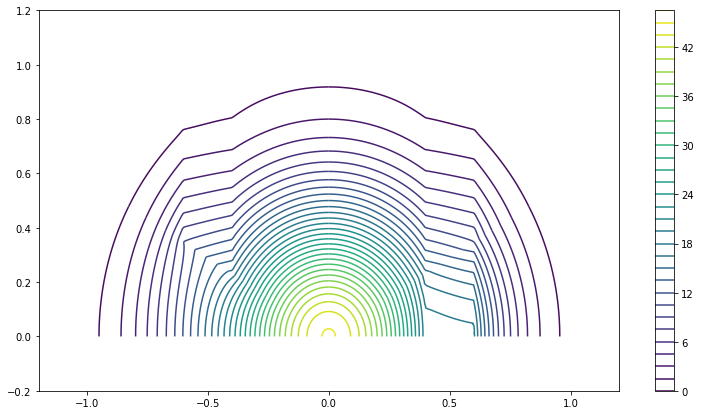

In [88]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

@mfem.jit.scalar()
def x(p):
    return p[0]
@mfem.jit.scalar()
def y(p):
    return p[1]

def dom_plot(sol_gf, fes, axes, flip = False, return_tpc = False):
    x_gf = mfem.GridFunction(fes)
    y_gf = mfem.GridFunction(fes)
    
    x_gf.ProjectCoefficient(x)
    y_gf.ProjectCoefficient(y)
    
    if (flip):
        triang = tri.Triangulation(x_gf.GetDataArray()*-1, y_gf.GetDataArray())
    else:
        triang = tri.Triangulation(x_gf.GetDataArray(), y_gf.GetDataArray())
    if (log_scale):
        if (contour):
            tpc = axes.tricontour(triang, log(sol_gf.GetDataArray()), levels = 30) #, shading='gouraud')
        else:
            tpc = axes.tripcolor(triang, log(sol_gf.GetDataArray()))#, shading='gouraud')
    else:
        if (contour):
            tpc = axes.tricontour(triang, sol_gf.GetDataArray(), levels = 30) #, shading='gouraud')
        else:
            tpc = axes.tripcolor(triang, sol_gf.GetDataArray())#, shading='gouraud')
    
    if (return_tpc):
        return tpc
        

fig, ax = plt.subplots(figsize = (13,7))

dom_plot(fp_right, fes_h1_2d_right, ax)
dom_plot(fp_left, fes_h1_2d_left, ax)
dom_plot(fp_mid, fes_h1_2d_mid, ax)
tpc = dom_plot(fp_mid, fes_h1_2d_mid, ax, True, True)
fig.colorbar(tpc)

plt.xlim(-1.2,1.2)
plt.ylim(-0.2,1.2)
plt.show()

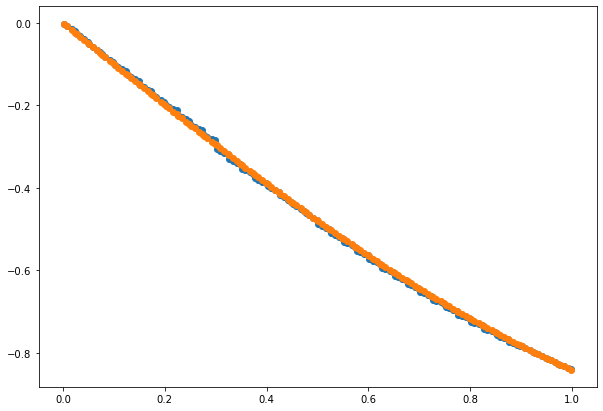

In [89]:
#flux op test
v2 = lambda theta : np.array([cos(theta), sin(theta)])
if (1):
    def one(p):
        return 1

    @mfem.jit.scalar()
    def cos_co(p):
        return cos(np.sqrt(p[0]**2+p[1]**2))

    @mfem.jit.scalar()
    def dcos_co(p):
        return -sin(np.sqrt(p[0]**2+p[1]**2))

    @mfem.jit.scalar()
    def r(p):
        return np.sqrt((p[0]**2 + p[1]**2))
    
    
    deriv_ang = pi/6
    test_deriv_angle = v2(deriv_ang)
    test_angle = pi/6
    
    directed_flux_op_left, r_vec_flux = directed_flux_op(bdr_right, fes_l2, bdr_mesh, fes_h1_2d_right, right_mesh, test_deriv_angle, pnt_rotation_trans, one, test_angle, ret_r_vec = True)
    r_vec = mfem.GridFunction(fes_l2)
    dr_vec = mfem.GridFunction(fes_l2)
    r_vec.ProjectCoefficient(r)
    dr_vec.ProjectCoefficient(dcos_co)
    
    
    d_actual = mfem.GridFunction(fes_h1_2d_right)
    d_actual.ProjectCoefficient(dcos_co)
    d_actual.Save("actual_deriv.gf")
    right_mesh.Save("right_2d.msh")

    left_gf_cos = mfem.GridFunction(fes_h1_2d_right)
    left_gf_cos.ProjectCoefficient(cos_co)

    test_flux = mfem.GridFunction(fes_l2)
    directed_flux_op_left.Mult(left_gf_cos, test_flux)
    
    thing = test_flux.GetDataArray()
    other_thing = np.zeros(thing.size)
    
    for i in range(int(thing.size/order)):
        for j in range(order):
            other_thing[j+i*order] = thing[i*order + (order - j - 1)]
            
    r_vec_sorted = np.sort(r_vec.GetDataArray())
    
            
    fix, ax = plt.subplots(figsize=(10,7))
#     plt.scatter(r_vec_sorted, other_thing) #reordered elementwise (for loops above)
    plt.scatter(r_vec_flux, test_flux.GetDataArray()) #directly from flux operator
#     print(test_flux.GetDataArray().size)
    plt.scatter(r_vec.GetDataArray(), dr_vec.GetDataArray())

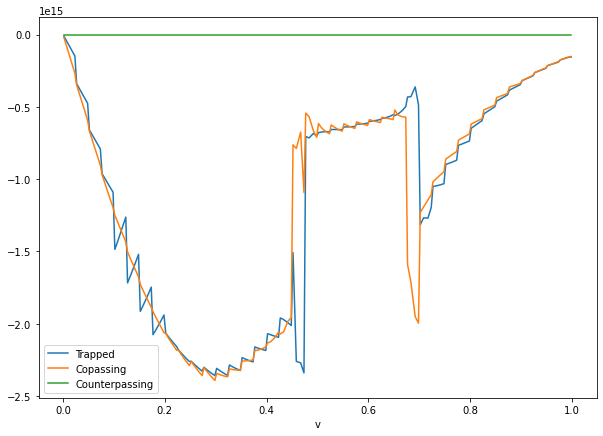

In [126]:
#plot flux on bdrs
ang = pi / 6.0
radial = False
if (radial):
    ang += pi/2

directed_flux_op_left, r_vec_left = directed_flux_op(bdr_left, fes_l2, bdr_mesh, fes_h1_2d_left, left_mesh, v2(pi-ang), pnt_rotation_trans, flux_F, (pi-ang), ret_r_vec = True)
fp_left_flux_theta = mfem.Vector(directed_flux_op_left.Height())
directed_flux_op_left.Mult(fp_left, fp_left_flux_theta)

directed_flux_op_mid, r_vec_mid = directed_flux_op(bdr_mid, fes_l2, bdr_mesh, fes_h1_2d_mid, mid_mesh, v2(pi/6), pnt_rotation_trans, flux_F, ang, ret_r_vec = True)
fp_mid_flux_theta = mfem.Vector(directed_flux_op_mid.Height())
directed_flux_op_mid.Mult(fp_mid, fp_mid_flux_theta)

directed_flux_op_right, r_vec_right = directed_flux_op(bdr_right, fes_l2, bdr_mesh, fes_h1_2d_right, right_mesh, v2(pi/6), pnt_rotation_trans, flux_F, ang, ret_r_vec = True)
fp_right_flux_theta = mfem.Vector(directed_flux_op_right.Height())
directed_flux_op_right.Mult(fp_right, fp_right_flux_theta)

flux_sum_theta = fp_left_flux_theta.GetDataArray() + fp_right_flux_theta.GetDataArray() - 2*fp_mid_flux_theta.GetDataArray()

fig_flux_theta, ax_flux_theta = plt.subplots(figsize=(10,7))
plt.plot(r_vec_left, fp_mid_flux_theta.GetDataArray(), label = "Trapped")
plt.plot(r_vec_left, fp_right_flux_theta.GetDataArray(), label = "Copassing")
plt.plot(r_vec_left, fp_left_flux_theta.GetDataArray(), label = "Counterpassing")
# plt.plot(r_vec_left, flux_sum_theta, label = "Sum")
plt.legend()
plt.xlabel("v")
plt.show()

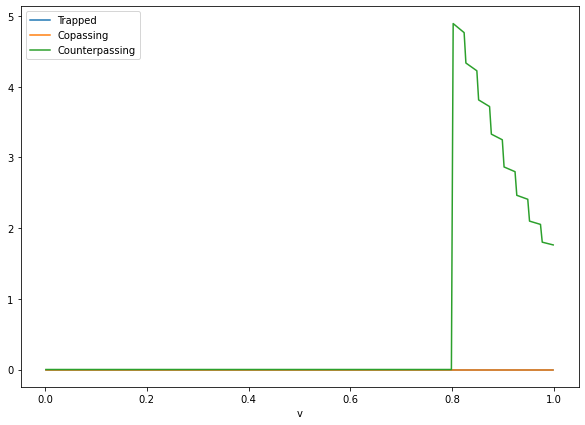

In [186]:
radial = True
ang = pi/6.0
if (radial):
    ang += pi/2

directed_flux_op_left_rad, r_vec_left = directed_flux_op(bdr_left, fes_l2, bdr_mesh, fes_h1_2d_left, left_mesh, v2(5*pi/6), pnt_rotation_trans, flux_E, (pi-ang), ret_r_vec = True)
fp_left_flux_rad = mfem.Vector(directed_flux_op_left_rad.Height())
directed_flux_op_left_rad.Mult(fp_left, fp_left_flux_rad)

directed_flux_op_mid_rad, r_vec_mid = directed_flux_op(bdr_mid, fes_l2, bdr_mesh, fes_h1_2d_mid, mid_mesh, v2(pi/6), pnt_rotation_trans, flux_E, ang, ret_r_vec = True)
fp_mid_flux_rad = mfem.Vector(directed_flux_op_mid_rad.Height())
directed_flux_op_mid_rad.Mult(fp_mid, fp_mid_flux_rad)

directed_flux_op_right_rad, r_vec_right = directed_flux_op(bdr_right, fes_l2, bdr_mesh, fes_h1_2d_right, right_mesh, v2(pi/6), pnt_rotation_trans, flux_E, ang, ret_r_vec = True)
fp_right_flux_rad = mfem.Vector(directed_flux_op_right_rad.Height())
directed_flux_op_right_rad.Mult(fp_right, fp_right_flux_rad)

flux_sum_rad = fp_left_flux_rad.GetDataArray() + fp_right_flux_rad.GetDataArray() - 2*fp_mid_flux_rad.GetDataArray()

fig_flux_rad, ax_flux_rad = plt.subplots(figsize=(10,7))
plt.plot(r_vec_mid, fp_mid_flux_rad.GetDataArray(), label = "Trapped")
plt.plot(r_vec_right, fp_right_flux_rad.GetDataArray(), label = "Copassing")
plt.plot(r_vec_left, fp_left_flux_rad.GetDataArray(), label = "Counterpassing")
# plt.plot(r_vec_left, flux_sum_rad, label = "Sum")
plt.legend()
plt.xlabel("v")
plt.show()

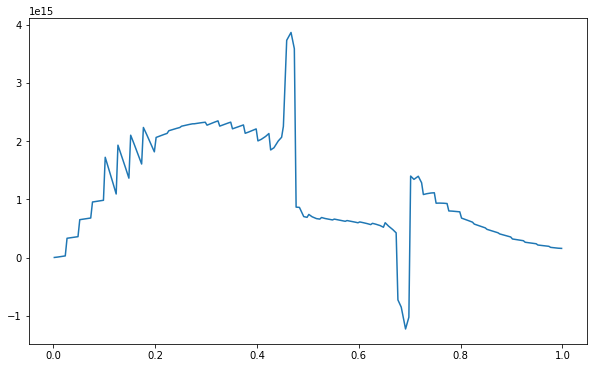

In [187]:
flux_sum = flux_sum_rad + flux_sum_theta

fig_sum, ax_sum = plt.subplots(figsize=(10,6))
plt.plot(r_vec_left, flux_sum)